In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [39]:
def is_inside_qpd(qpd_diameter):
    r = (xg**2 + yg**2)**0.5
    return r <= qpd_diameter / 2

def is_in_quadrant(quadrant_id):
    g = qpd_gap / 2
    if quadrant_id == 1:
        return (xg < -g) & (yg > g)
    elif quadrant_id == 2:
        return (xg > g) & (yg > g)
    elif quadrant_id == 3:
        return (xg > g) & (yg < -g)
    elif quadrant_id == 4:
        return (xg < -g) & (yg < -g)
    else:
        return 0

def gaussian_beam(beam_pos, beam_cutoff_diameter, gaussian_width):
    bx = beam_pos[0]
    by = beam_pos[1]

    sigma_x = gaussian_width
    sigma_y = gaussian_width

    dx = (xg - bx)**2 / (2 * sigma_x**2)
    dy = (yg - by)**2 / (2 * sigma_y**2)
    
    beam = np.exp(-(dx + dy))

    beam[~is_inside_beam(beam_pos, beam_cutoff_diameter)] = 0
    return beam

def is_inside_beam(beam_pos, beam_diameter):
    bx = beam_pos[0]
    by = beam_pos[1]
    r = ((xg - bx)**2 + (yg - by)**2)**0.5
    return r <= beam_diameter / 2

def integrate_quadrants(beam_pos, beam_diameter):
    q_count = np.zeros(4)
    for i in range(0, 4):
        quadrant_id = i + 1
        b = gaussian_beam(beam_pos, beam_diameter, beam_diameter/2)
        b1 = b[is_inside_qpd(qpd_diameter) & is_in_quadrant(quadrant_id)]
        q_count[i] = np.sum(b1)
        #q_count[i] = np.sum(is_inside_beam(beam_pos, beam_diameter) & is_inside_qpd(qpd_diameter) & is_in_quadrant(quadrant_id))
    return q_count
        
def calc_qpd_outputs(q_count):
    Q1 = q_count[0]
    Q2 = q_count[1]
    Q3 = q_count[2]
    Q4 = q_count[3]
    Xdiff = (Q2 + Q3) - (Q4 + Q1)
    Ydiff = (Q1 + Q2) - (Q3 + Q4)
    SUM = Q1 + Q2 + Q3 + Q4
    return Xdiff, Ydiff, SUM

def normalise_qpd(Xdiff, Ydiff, SUM):
    X = Xdiff / SUM
    Y = Ydiff / SUM
    return X, Y

def evaluate_qpd(beam_pos, beam_diameter):
    q_count = integrate_quadrants(beam_pos, beam_diameter)
    Xdiff, Ydiff, SUM = calc_qpd_outputs(q_count)
    X, Y = normalise_qpd(Xdiff, Ydiff, SUM)
    return X, Y, SUM

In [36]:
x = np.arange(-5, 5, 0.05)
y = np.arange(-5, 5, 0.05)
xg, yg = np.meshgrid(x, y)

qpd_diameter = 7.8 # [mm]
qpd_gap = 0.1 # mm

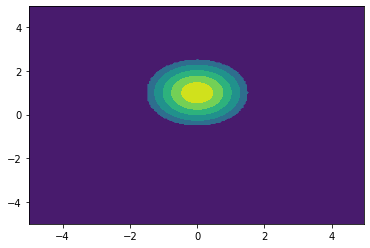

In [42]:
z = gaussian_beam((0, 1), 3, 1)
plt.contourf(x, y, z)

In [5]:
beam_pos = (0, 0)
beam_diameter = 8
X, Y, SUM = evaluate_qpd(beam_pos, beam_diameter)
print(X, Y, SUM)

-0.008167901768810515 -0.008167901768810515 18487.0


In [25]:
beam_diameter = 1.5# qpd_diameter / 2

bx_array = np.arange(-6, 6, 0.1)
by_array = np.zeros_like(bx_array)

qpd_X = np.zeros_like(by_array)
qpd_Y= np.zeros_like(by_array)
qpd_SUM = np.zeros_like(by_array)

for i in range(len(by_array)):
    beam_pos = (bx_array[i], by_array[i])
    qpd_X[i], qpd_Y[i], qpd_SUM[i] = evaluate_qpd(beam_pos, beam_diameter)


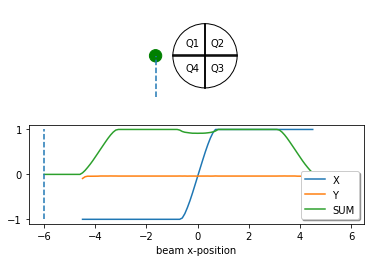

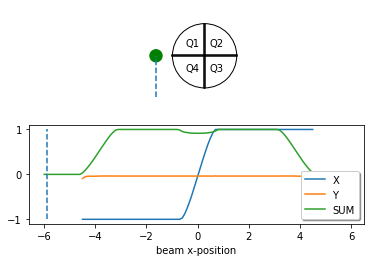

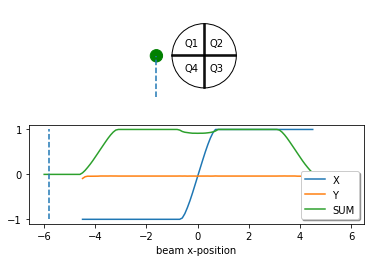

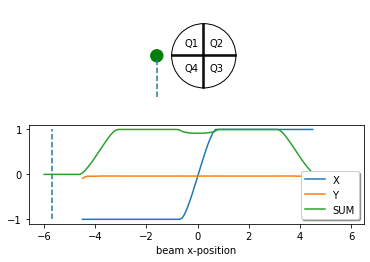

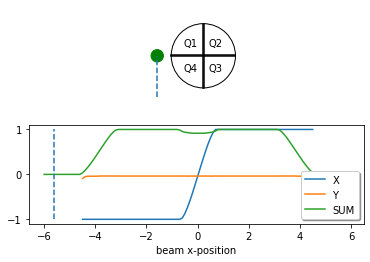

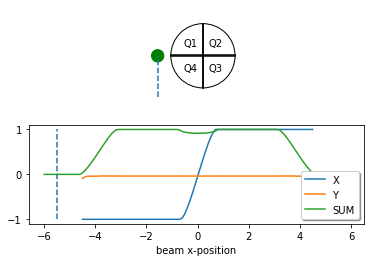

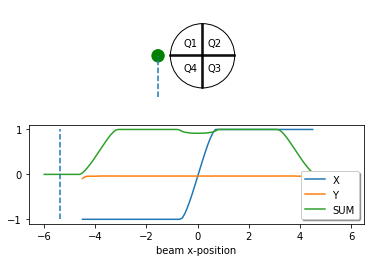

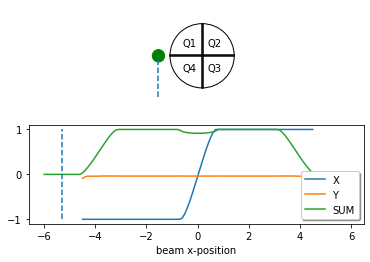

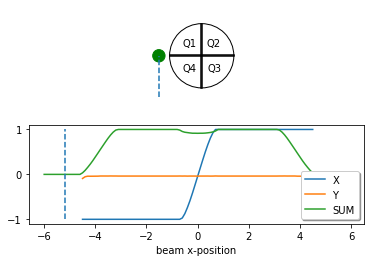

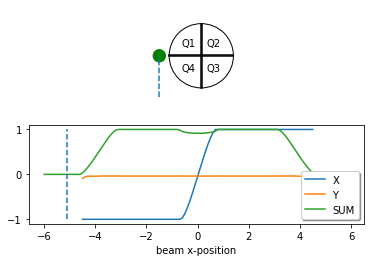

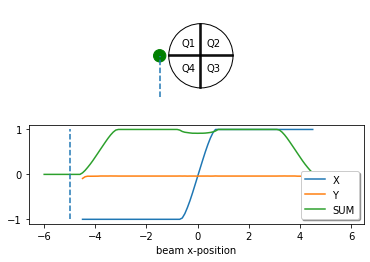

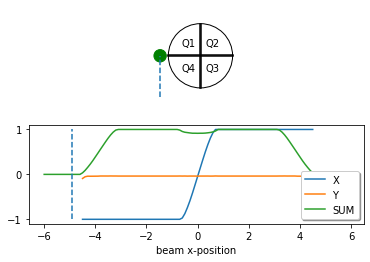

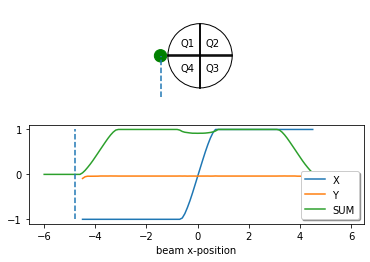

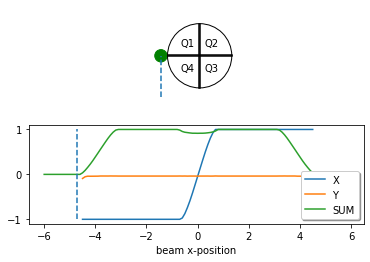

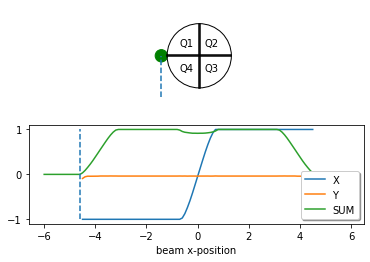

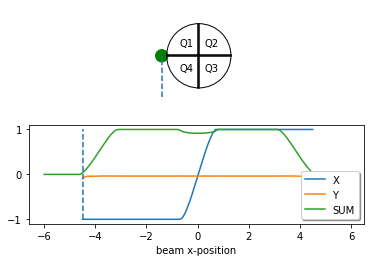

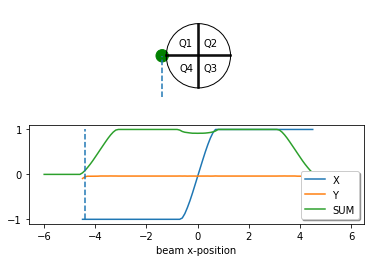

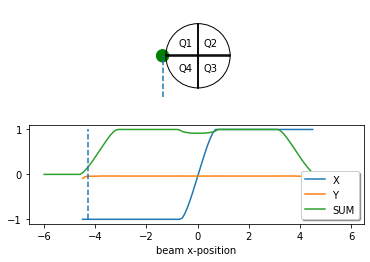

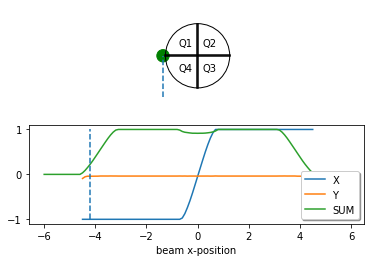

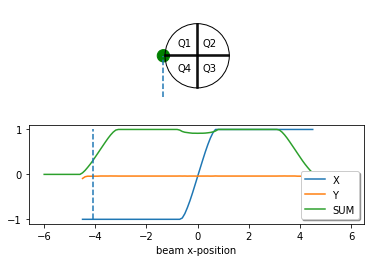

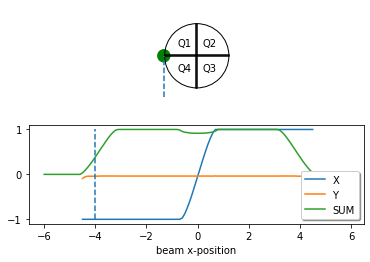

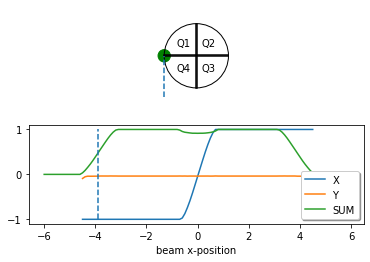

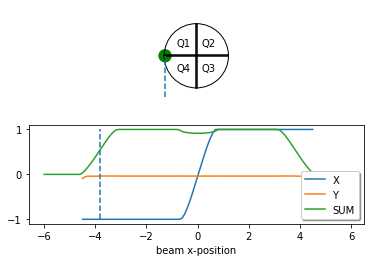

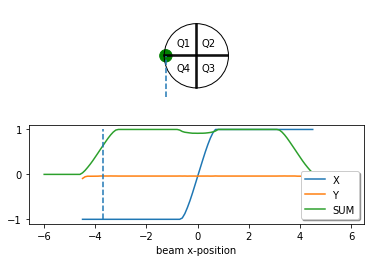

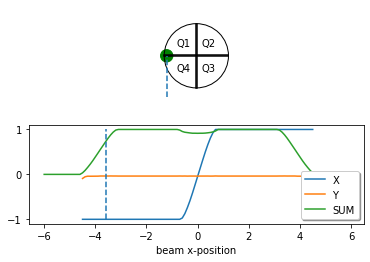

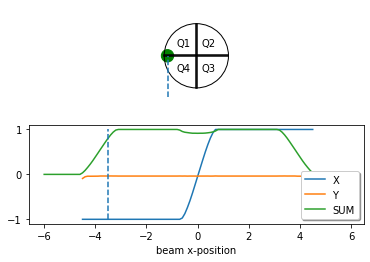

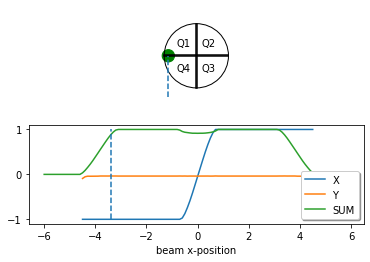

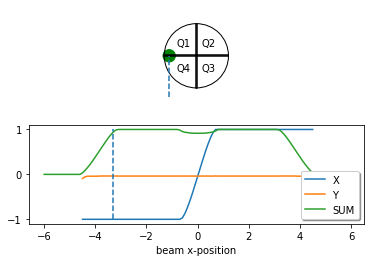

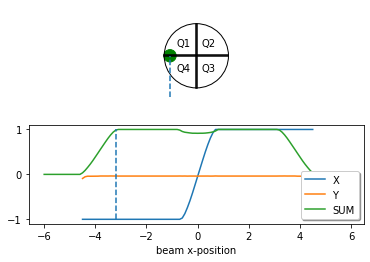

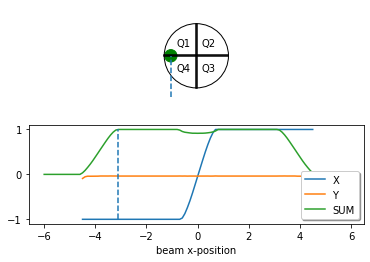

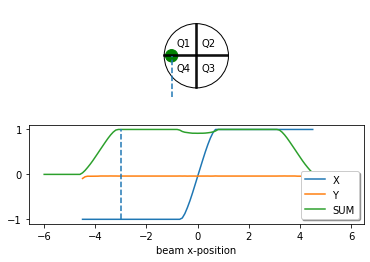

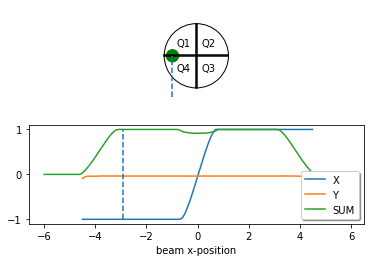

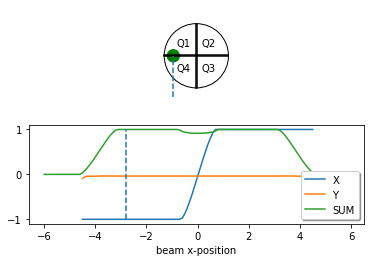

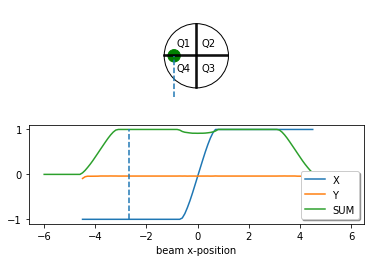

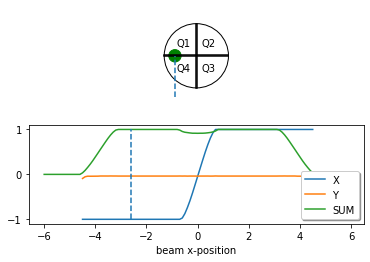

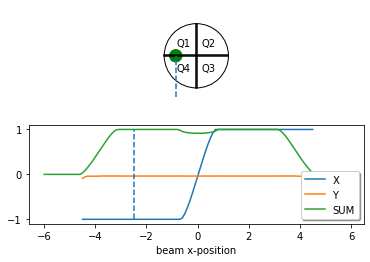

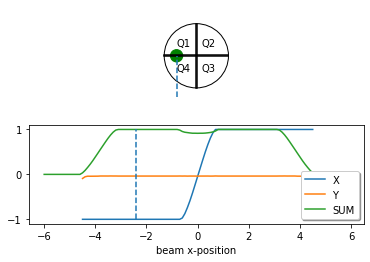

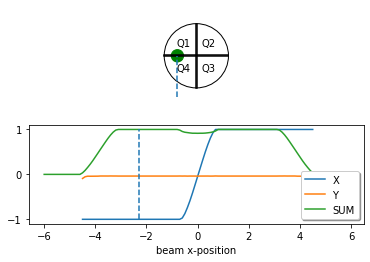

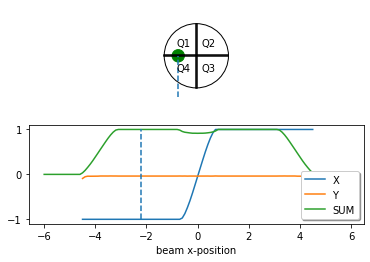

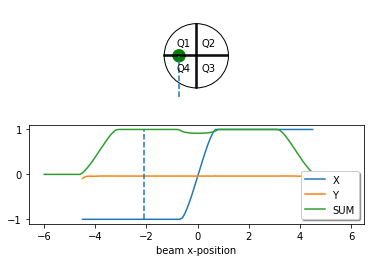

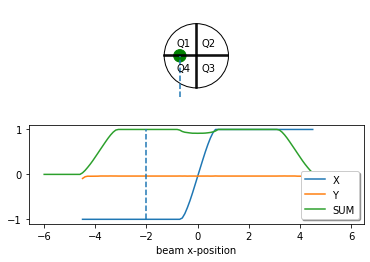

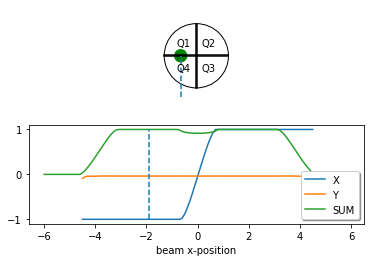

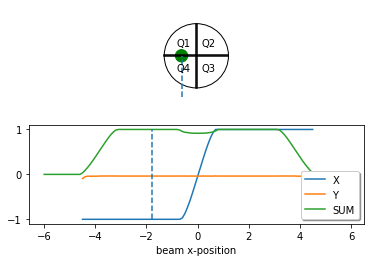

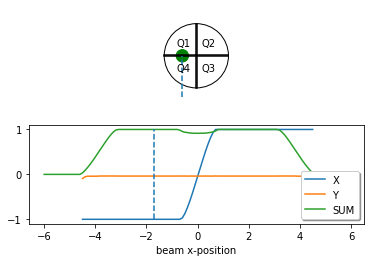

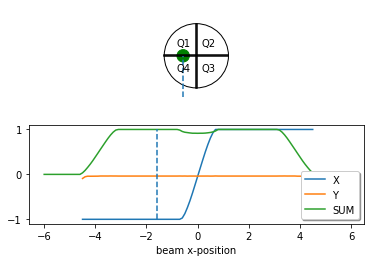

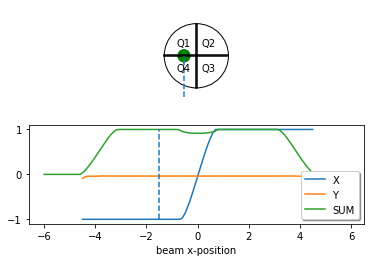

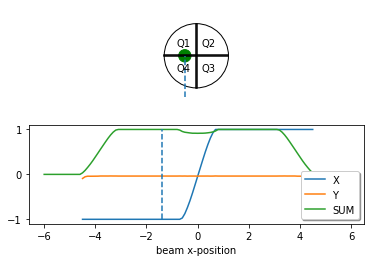

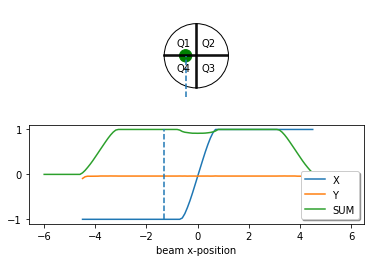

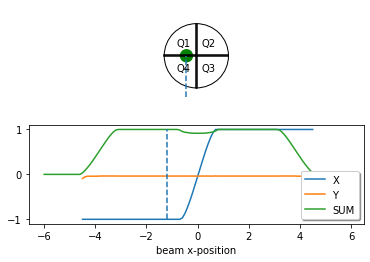

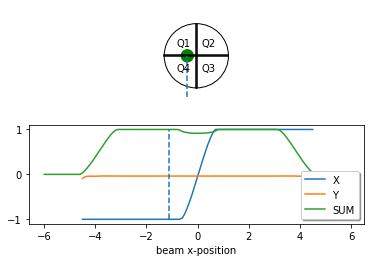

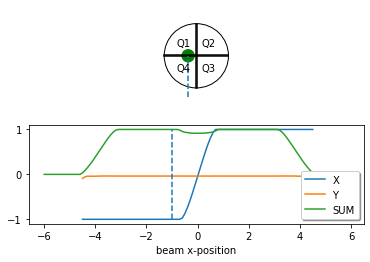

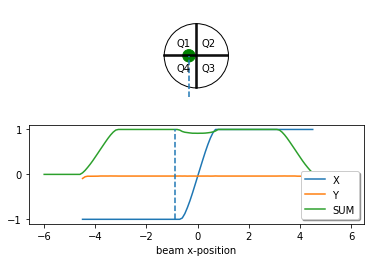

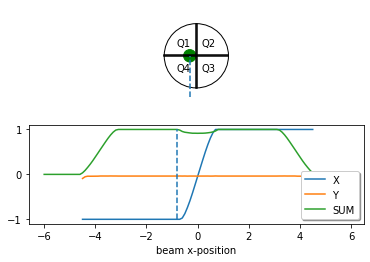

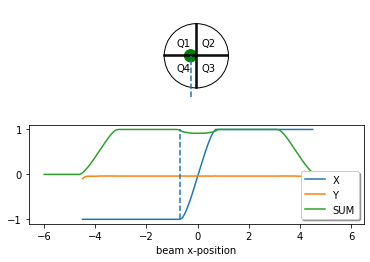

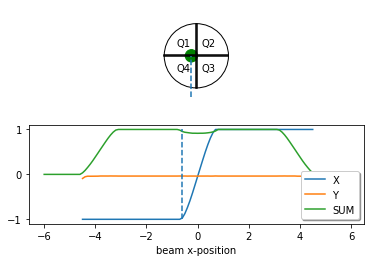

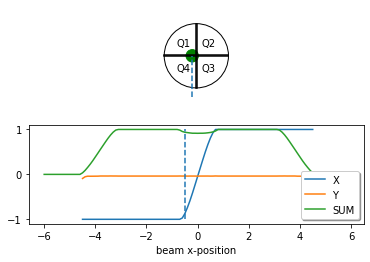

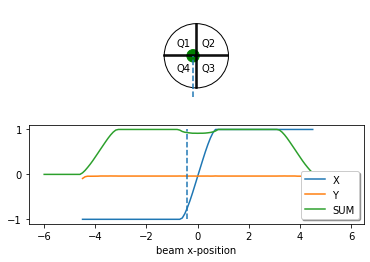

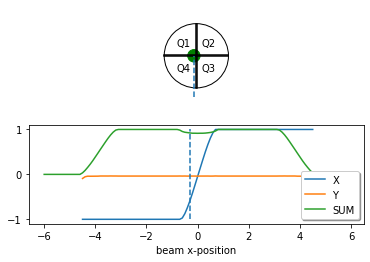

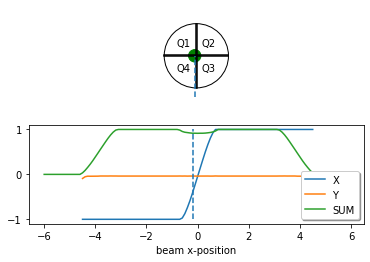

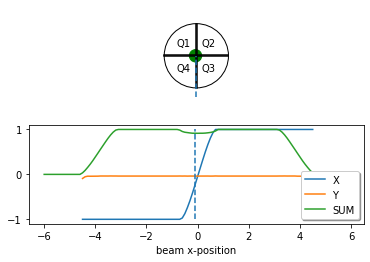

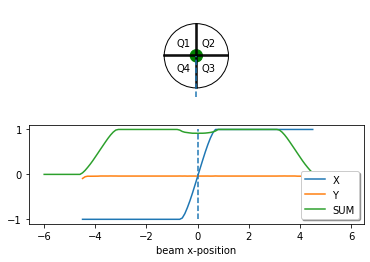

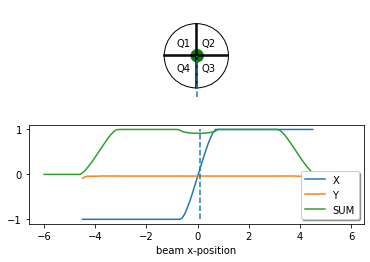

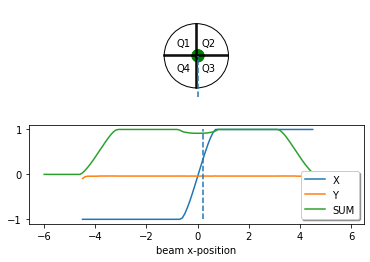

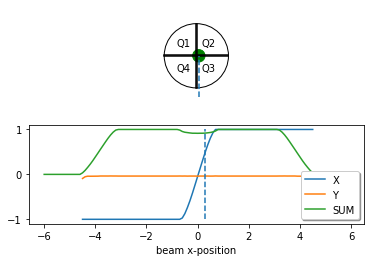

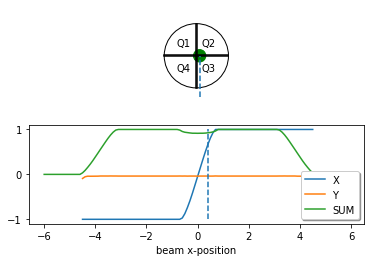

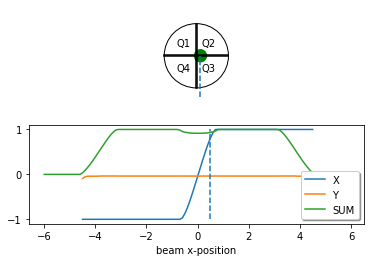

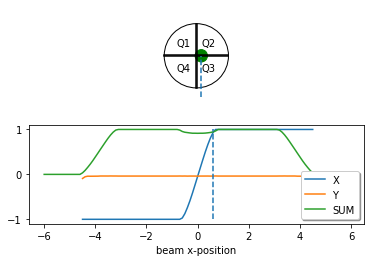

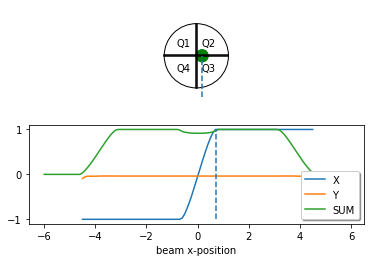

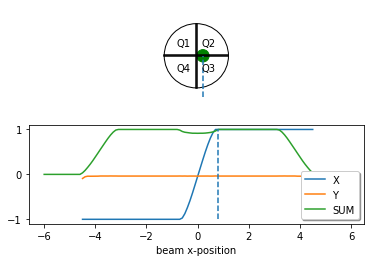

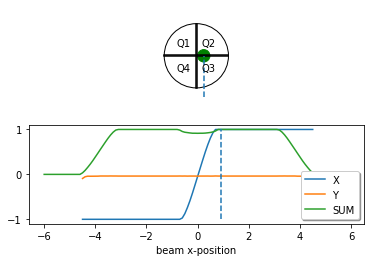

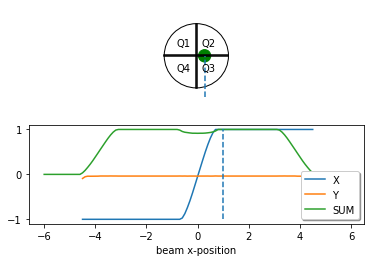

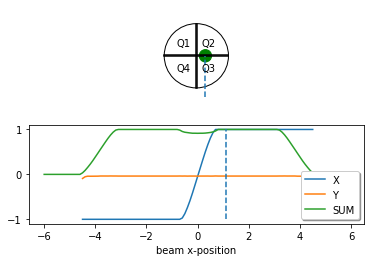

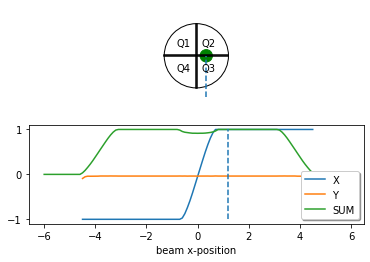

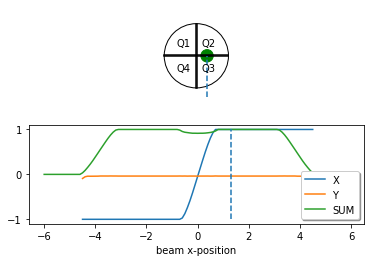

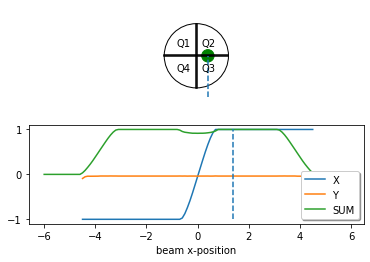

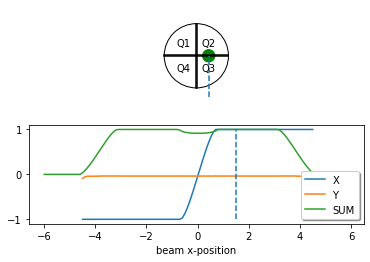

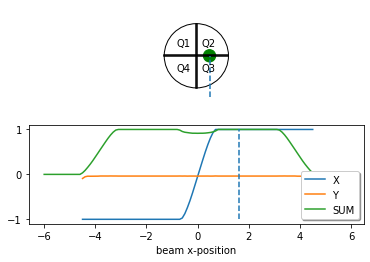

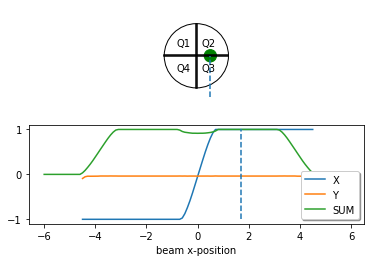

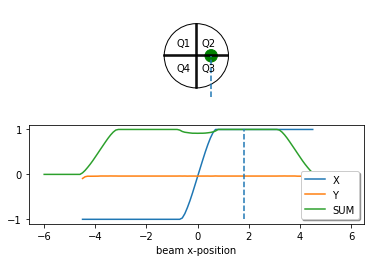

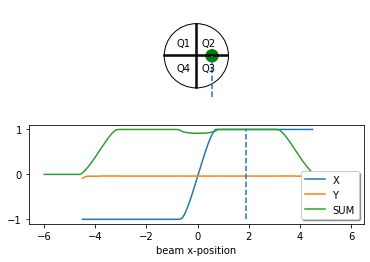

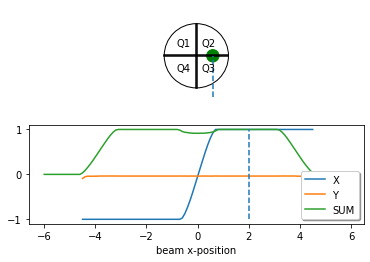

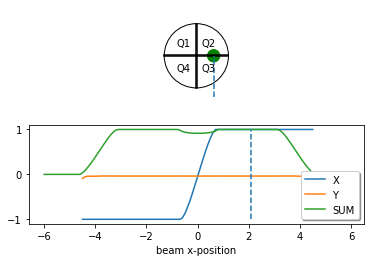

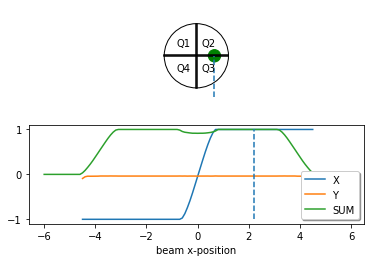

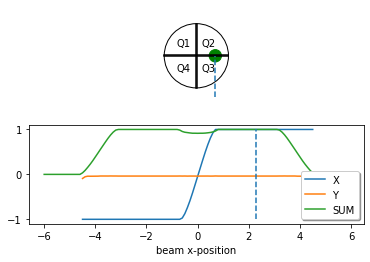

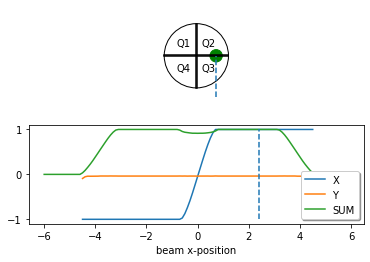

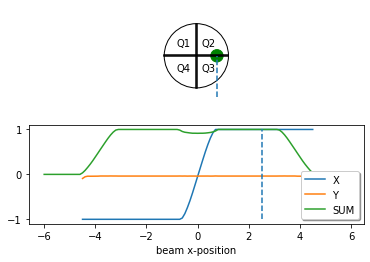

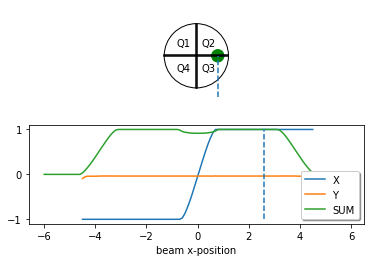

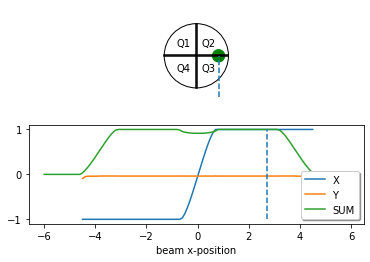

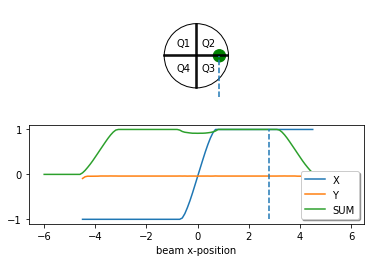

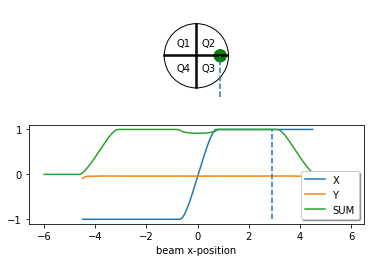

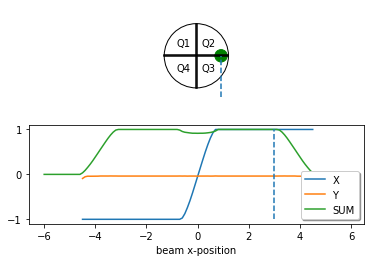

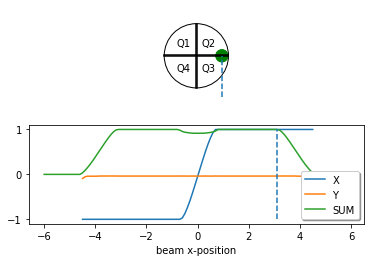

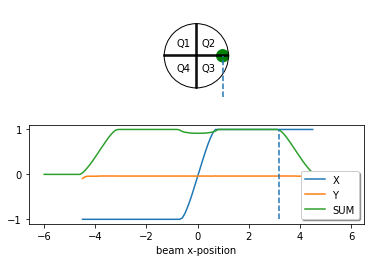

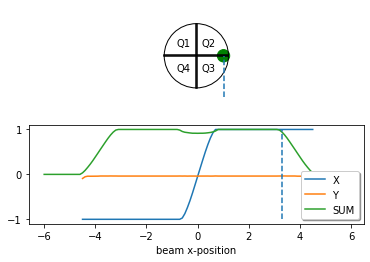

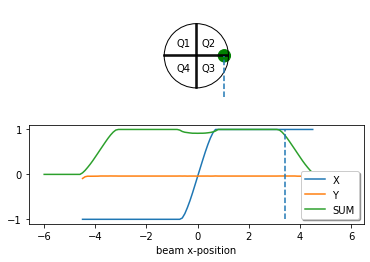

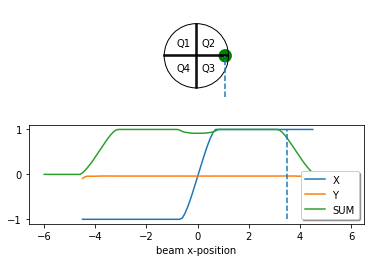

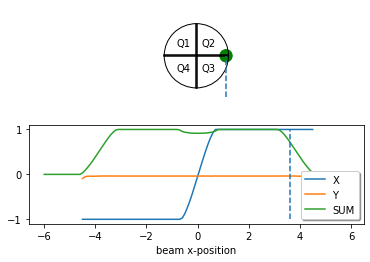

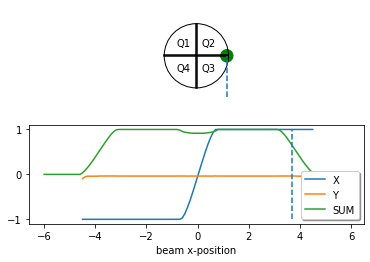

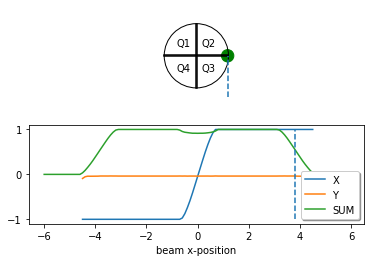

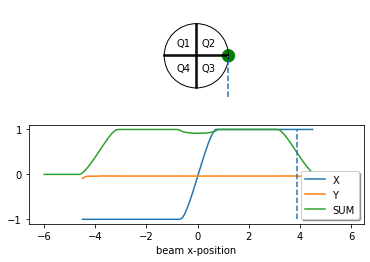

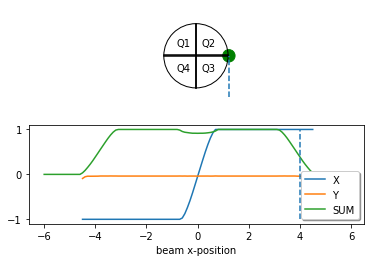

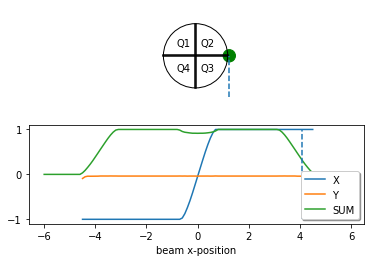

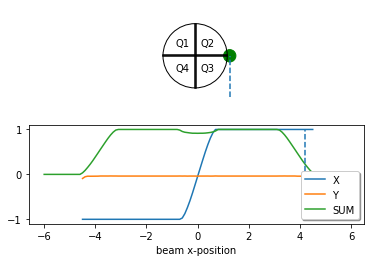

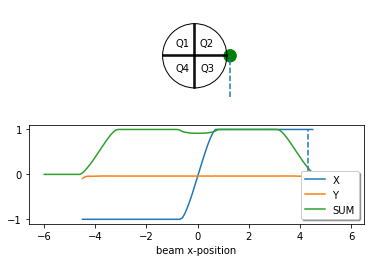

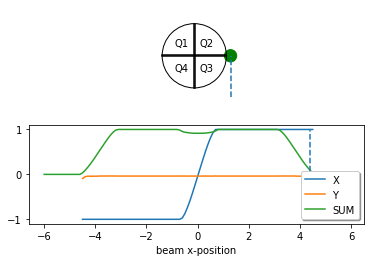

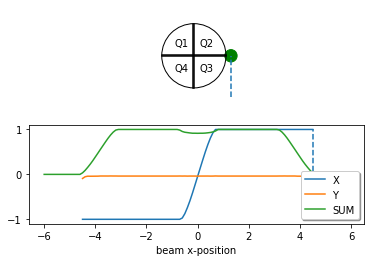

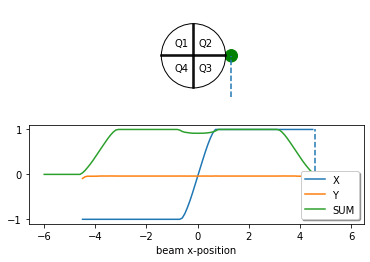

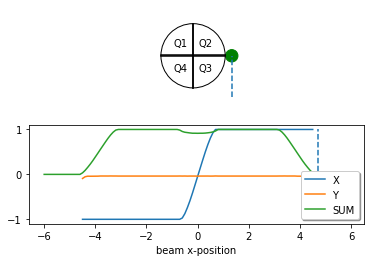

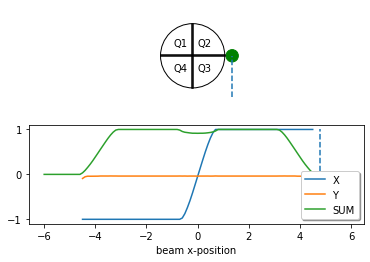

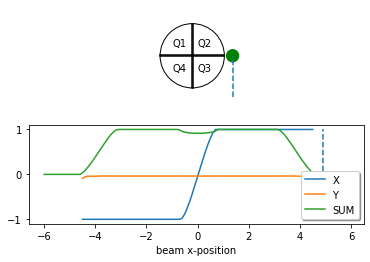

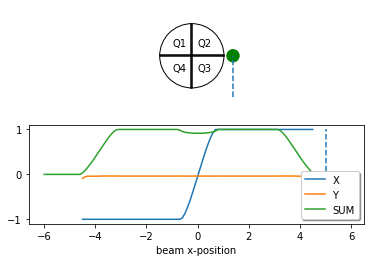

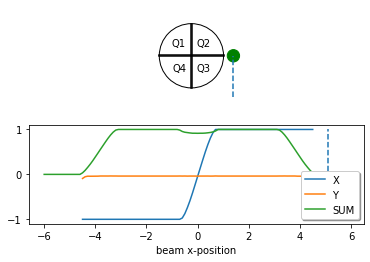

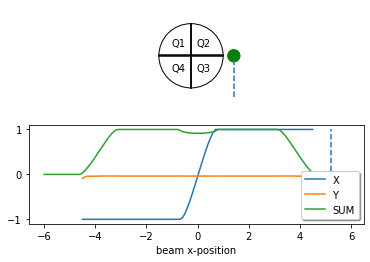

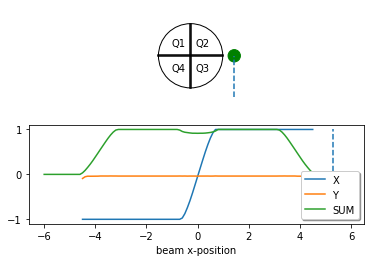

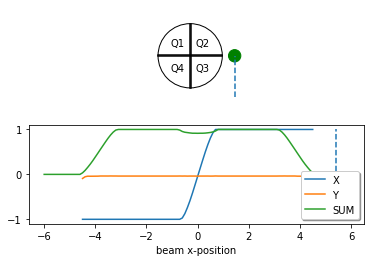

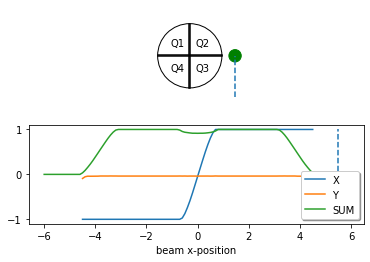

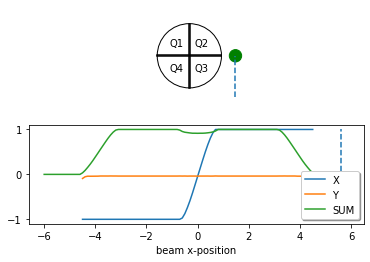

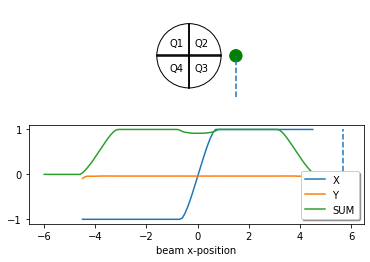

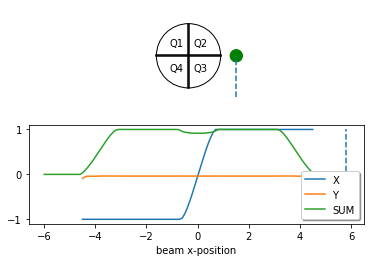

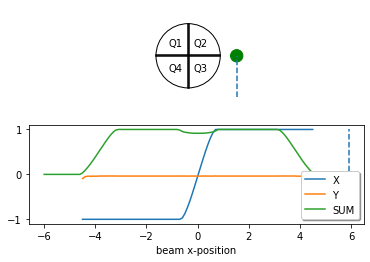

In [26]:
def plot_qpd_diagram(beam_pos, sweep_axis):
    fig, ax = plt.subplots(2, 1)

    # Beam
    beam = plt.Circle((beam_pos), beam_diameter / 2, color='g', fill=True)
    ax[0].add_artist(beam)

    # QPD
    qpd = plt.Circle((0, 0), qpd_diameter / 2, color='k', fill=False)
    ax[0].add_artist(qpd)

    ax[0].plot([-qpd_diameter / 2, qpd_diameter/2], [qpd_gap/2, qpd_gap/2], color='k') # top horizontal line
    ax[0].plot([-qpd_diameter / 2, qpd_diameter/2], [-qpd_gap/2, -qpd_gap/2], color='k') # bottom horizontal line
    ax[0].plot([qpd_gap/2, qpd_gap/2], [-qpd_diameter / 2, qpd_diameter/2], color='k') # right vertical line
    ax[0].plot([-qpd_gap/2, -qpd_gap/2], [-qpd_diameter / 2, qpd_diameter/2], color='k') # left vertical line

    ax[0].text(-1.5, 1.5, 'Q1', horizontalalignment='center', verticalalignment='center')
    ax[0].text(1.5, 1.5, 'Q2', horizontalalignment='center', verticalalignment='center')
    ax[0].text(1.5, -1.5, 'Q3', horizontalalignment='center', verticalalignment='center')
    ax[0].text(-1.5, -1.5, 'Q4', horizontalalignment='center', verticalalignment='center')

    ax[0].axis('equal')
    ax[0].set(ylim=(-6, 6))
    ax[0].axis('off')

    if sweep_axis == 'x':
        ax[1].plot(bx_array, qpd_X, label='X')
        ax[1].plot(bx_array, qpd_Y, label='Y')
        ax[1].plot(bx_array, qpd_SUM/np.max(qpd_SUM), label='SUM')
        ax[0].plot([beam_pos[0], beam_pos[0]], [-5, 0], color='C0', linestyle='--') # vertical dotted line on beam midpoint
        ax[1].plot([beam_pos[0], beam_pos[0]], [-1, 1], color='C0', linestyle='--') # vertical dotted line on graph
        ax[1].set_xlabel('beam x-position')
    elif sweep_axis == 'y':
        ax[1].plot(by_array, qpd_X)
        ax[1].plot(by_array, qpd_Y)
        ax[1].plot(by_array, qpd_SUM/np.max(qpd_SUM))
        ax[0].plot([-5, 0], [beam_pos[1], beam_pos[1]], color='C1', linestyle='--') # horizontal dotted line on beam midpoint
        ax[1].plot([beam_pos[1], beam_pos[1]], [-1, 1], color='C1', linestyle='--') # vertical dotted line on graph

    legend = ax[1].legend(loc='lower right', shadow=True)
    #plt.show() 

    # naming files
    fig_name = ("{:0>3d}".format(i) + "_" + sweep_axis 
        + "-sweep_bx={:.1f}".format(beam_pos[0]) + "_by={:.1f}".format(beam_pos[1])
        + "_bd={:.2f}".format(beam_diameter))
    #print(fig_name)
    plt.savefig(f'figures/{fig_name}.png', format='png')

for i in range(0, len(by_array), 1):
    beam_pos = (bx_array[i], by_array[i])
    plot_qpd_diagram(beam_pos, 'x')

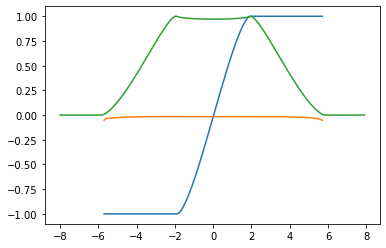

In [37]:
plt.plot(bx_array, qpd_X)
plt.plot(bx_array, qpd_Y)
plt.plot(bx_array, qpd_SUM/np.max(qpd_SUM))

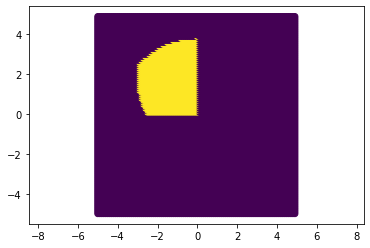

In [48]:
plt.scatter(xg, yg, c=a)
plt.axis('equal')
plt.show()